<div style="text-align:center">
    <h1>
        Off-policy Monte Carlo Control
    </h1>
</div>
<br>

In this notebook we are going to implement the other of the two major strategies that exist when learning a policy by interacting with the environment, called off-policy learning. We will use two policies: 
    
- An exploratory policy called b.
    
- A target policy that will learn from the experience collected by b, called $\pi$

<br><br>
<div style="text-align:center">
    <b>This notebook belongs to section 4 of the course "Reinforcement Learning: beginner to master".</b>
    <br><br>
    <a href="https://www.udemy.com">Reinforcement Learning: beginner to master</a> (English)
    <br>
    <a href="https://www.udemy.com">Reinforcement Learning: de principiante a maestro</a> (Spanish)
</div>

<br>

<table style="width:35%">
  <tr style="background-color: transparent">
    <td style="width: 45%">
        <a target="_parent" href="https://www.evlabs.io" style="float: center">
            <img src="img/evlabs-square.png" width="75"/>
        </a> 
    </td>
    <td valign="bottom">
        <a target="_parent" href="https://www.youtube.com/channel/UCksRNSzWuMV5IfdrPlglqqw">
            <img src="img/YouTube.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://www.linkedin.com/company/evlabs">
            <img src="img/LinkedIn.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://twitter.com/evelabs">
            <img src="img/Twitter.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://github.com/escape-velocity-labs/">
            <img src="img/GitHub.png" width="35"/>
        </a> 
    </td>

  </tr>
  <tr style="background-color: transparent">
    <th style="text-align: center; width: 70%">Escape Velocity Labs</th>
  </tr>

</table>

<br>

## Import the necessary software libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from envs import Maze
from utils import plot_policy, plot_action_values, test_agent

## Initialize the environment

In [2]:
env = Maze()

D:\Users\apytl\AppData\Anaconda3\envs\bmrl\lib\site-packages\pyglet\image\codecs\wic.py:406: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


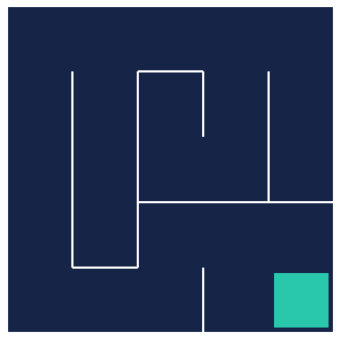

In [3]:
frame = env.render(mode='rgb_array')
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(frame)

In [4]:
print(f"Observation space shape: {env.observation_space.nvec}")
print(f"Number of actions: {env.action_space.n}")

Observation space shape: [5 5]
Number of actions: 4


## Define value table $Q(s, a)$

#### Create the $Q(s, a)$ table

In [10]:
action_values = np.full((5, 5, 4), -100) #-100 iniila values arbitrarily chosen
action_values[4, 4,:] = 0. #make sure that the value at the goal, because we dont expect any reward at the exit
action_values


array([[[-100, -100, -100, -100],
        [-100, -100, -100, -100],
        [-100, -100, -100, -100],
        [-100, -100, -100, -100],
        [-100, -100, -100, -100]],

       [[-100, -100, -100, -100],
        [-100, -100, -100, -100],
        [-100, -100, -100, -100],
        [-100, -100, -100, -100],
        [-100, -100, -100, -100]],

       [[-100, -100, -100, -100],
        [-100, -100, -100, -100],
        [-100, -100, -100, -100],
        [-100, -100, -100, -100],
        [-100, -100, -100, -100]],

       [[-100, -100, -100, -100],
        [-100, -100, -100, -100],
        [-100, -100, -100, -100],
        [-100, -100, -100, -100],
        [-100, -100, -100, -100]],

       [[-100, -100, -100, -100],
        [-100, -100, -100, -100],
        [-100, -100, -100, -100],
        [-100, -100, -100, -100],
        [   0,    0,    0,    0]]])

#### Plot $Q(s, a)$

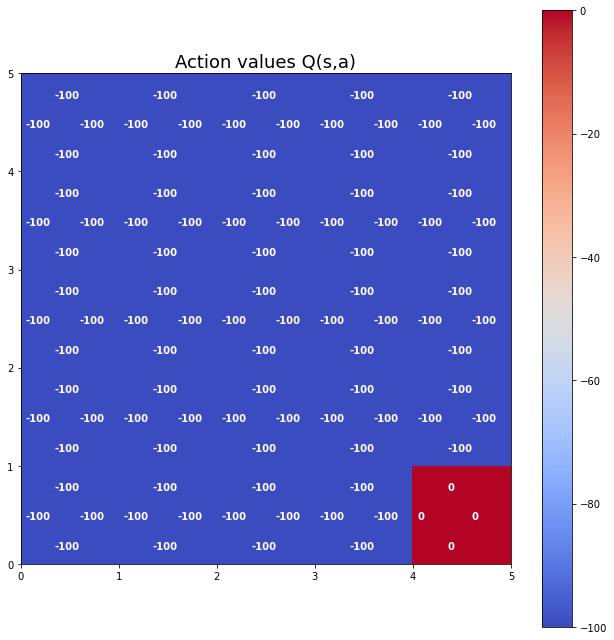

In [11]:
plot_action_values(action_values)

## Define the target policy $\pi(s)$

#### Create the policy $\pi(s)$

In [13]:
#remember that the policy can return either a prob of takin an action or the action to be taken

def target_policy(state):
    av = action_values[state] #fetch the q-value for the action in that state
    return np.random.choice(np.flatnonzero(av==av.max()))

#### Test the policy with state (0, 0)

In [16]:
action = target_policy((0,0))
print(f"Action taken in state (0,0):{action}")

Action taken in state (0,0):1


#### Plot the policy

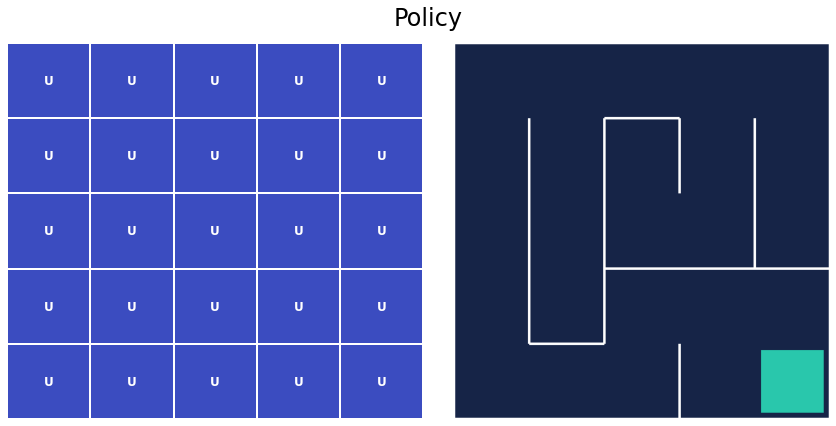

In [17]:
plot_policy(action_values, frame)# for the moment every action has the same value

## Define the exploratory policy $b(s)$

#### Create the policy $b(s)$

In [22]:
#epsilon is the prob that the policy picks a random action
def exploratory_policy(state, epsilon):
    if np.random.random() < epsilon:
        return np.random.choice(4)
    else:
        av =  action_values[state]
        return np.random.choice(np.flatnonzero(av==av.max()))

#### Test the policy with state (0, 0)

In [23]:
action  = exploratory_policy((0, 0), epsilon=.5)
print(f"Action taken in state (0, 0): {action}")

Action taken in state (0, 0): 3


## Implement the algorithm

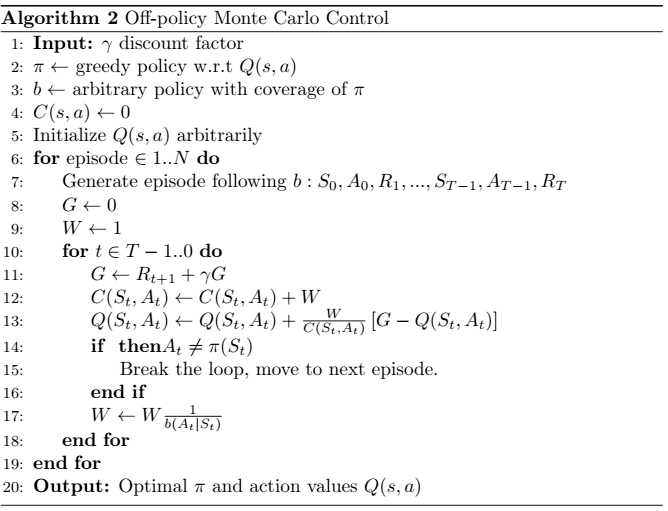

</br>



<div style="text-align:center">
    Adapted from Barto & Sutton: "Reinforcement Learning: An Introduction".
</div>

In [30]:
def off_policy_mc_control(action_values, target_policy, exploratory_policy, episodes, gamma=.99, epsilon=0.2):
    csa = np.zeros((5, 5, 4))
    
    for episode in range(1, episodes + 1):
        G = 0
        W = 1
        state = env.reset() #initialize the task for this episode and store the initial state
        done = False
        transitions = []
        
        while not done:
            action = exploratory_policy(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            transitions.append([state, action, reward])
            state = next_state
            
        for state_t, action_t, reward_t in reversed(transitions):
            G  = reward_t + gamma * G
            
            csa[state_t][action_t] += W
            qsa = action_values[state_t][action_t]
            
            action_values[state_t][action_t] += (W / csa[state_t][action_t]) * (G - qsa)
        
        #now we have to check if the action picked by the exploratory policy is the same that target policy would have pickes
        #after bein updated, If not we break the loop and move to the next episode
        
        if action_t != target_policy(state_t):
            break
        
        
        #update the iimptance sampling ratio
        
        W = W * 1./(1 - epsilon + epsilon / 4) # 4 available actions, 1 - epsilon is the prob of picking the highest q-value
    
    
    
    
    

In [31]:
off_policy_mc_control(action_values, target_policy, exploratory_policy, episodes=1000, epsilon=.3)

## Show results

#### Show resulting value table $Q(s, a)$

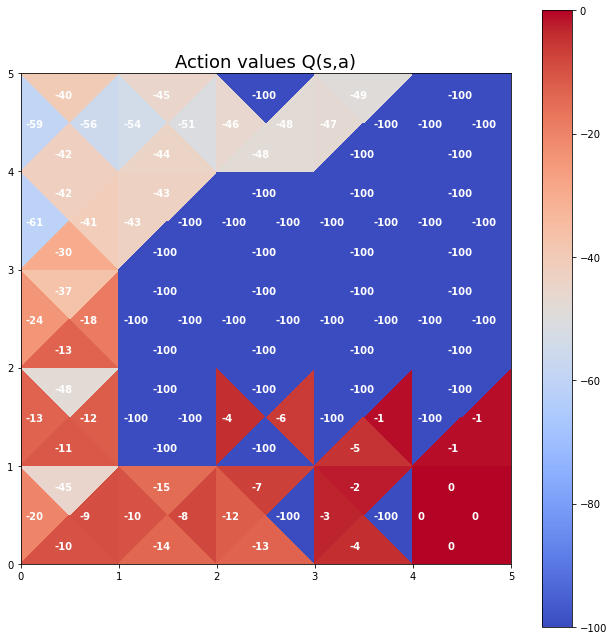

In [32]:
plot_action_values(action_values)

In [ ]:
# observe that the states that are not part of the optimal path have been practically ignored
#remember, one of the adv of using methods to learn based on experience is that we can focus our efforts on states and actions
#that lead us to solving the task in the optimal way

#### Show resulting policy $\pi(\cdot|s)$

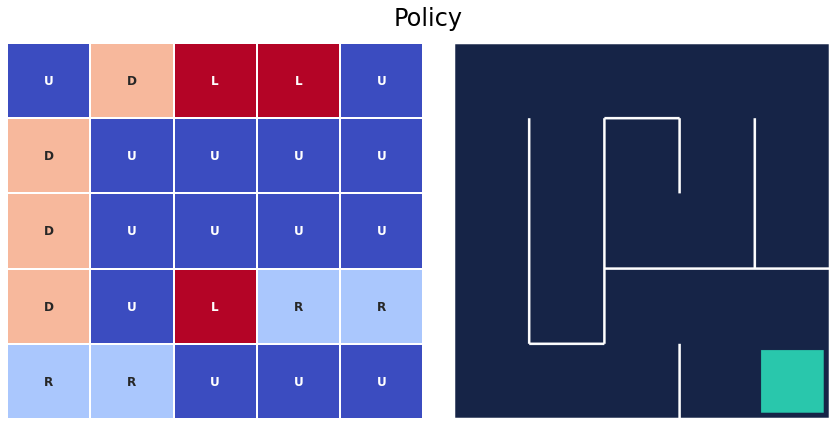

In [33]:
plot_policy(action_values, frame)

#### Test the resulting agent

MemoryError: Unable to allocate 1.03 MiB for an array with shape (600, 600, 3) and data type uint8

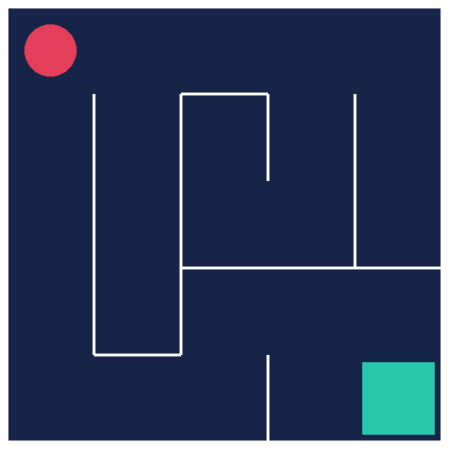

In [34]:
test_agent(env, target_policy)

## Resources

[[1] Reinforcement Learning: An Introduction. Ch. 5: Monte Carlo methods](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)